# Machine Learning - Opções Binárias

## EUR/USD Put/Call Predictor

## Importações

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import pickle

# Estratégia

#### O modelo combinará três indicadores técnicos poderosos - as Bandas de Bollinger, o Índice de Força Relativa (RSI) e o Oscilador Estocástico - para prever entradas binárias no par de moedas EUR/USD. As Bandas de Bollinger ajudarão a identificar possíveis pontos de reversão de tendência com base na volatilidade do mercado, enquanto o RSI indicará se o mercado está sobrecomprado ou sobrevendido. O Oscilador Estocástico complementará essas informações, fornecendo sinais de compra ou venda com base na comparação entre o preço de fechamento atual e o intervalo de preços ao longo de um período específico. Juntos, esses indicadores fornecerão uma abordagem abrangente para tomar decisões informadas sobre as entradas binárias no EUR/USD.

<div style="text-align:center;">
    <img src="img/img.jpg" width="750" height="750" />
</div>

## Estruturando e Visualizando os Dados

In [2]:
h = pd.read_csv('data/EURUSD_Candlestick_1_Hour_BID_03.05.2003-01.03.2024.csv')

In [3]:
df1 = pd.DataFrame(h)
display(df1.head())
display(df1.tail())

,Gmt time,Open,High,Low,Close,Volume
0,04.05.2003 00:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0
1,04.05.2003 01:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0
2,04.05.2003 02:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0
3,04.05.2003 03:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0
4,04.05.2003 04:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0


,Gmt time,Open,High,Low,Close,Volume
182611,02.03.2024 19:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0
182612,02.03.2024 20:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0
182613,02.03.2024 21:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0
182614,02.03.2024 22:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0
182615,02.03.2024 23:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0


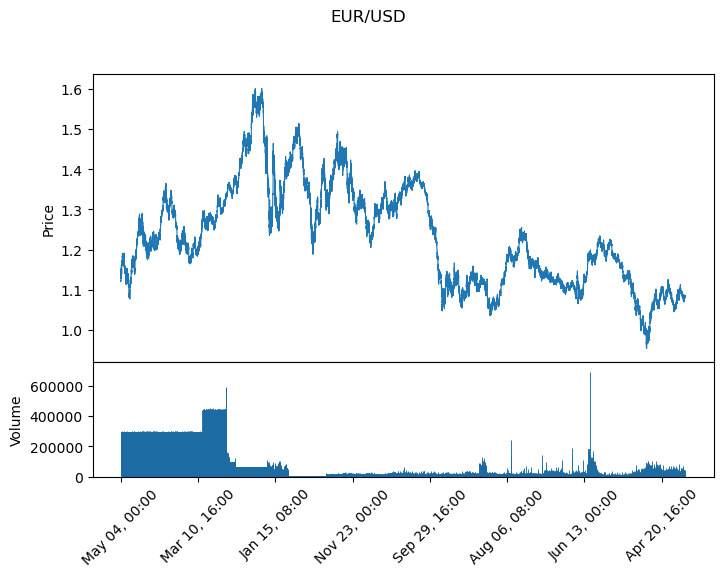

In [4]:
eur_usd = df1.copy()
eur_usd.index = pd.to_datetime(eur_usd['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')

eur_usd = eur_usd.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})

mc = mpf.make_marketcolors(up='g', down='r', wick='inherit', edge='inherit')
s = mpf.make_mpf_style(marketcolors=mc)
kwargs = dict(type='line', volume=True, figratio=(12,8), figscale=1.0, style=s, title='EUR/USD', warn_too_much_data=10000000)

mpf.plot(eur_usd, **kwargs)

In [5]:
# Adicionando Bandas de Bollinger
period = 20

df1['SMA'] = df1['Close'].rolling(window=period).mean()

df1['STD'] = df1['Close'].rolling(window=period).std()

df1['Upper'] = df1['SMA'] + (2 * df1['STD'])

df1['Lower'] = df1['SMA'] - (2 * df1['STD'])

display(df1.head())
display(df1.tail())

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower
0,04.05.2003 00:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN
1,04.05.2003 01:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN
2,04.05.2003 02:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN
3,04.05.2003 03:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN
4,04.05.2003 04:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN


,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower
182611,02.03.2024 19:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368
182612,02.03.2024 20:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368
182613,02.03.2024 21:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368
182614,02.03.2024 22:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368
182615,02.03.2024 23:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368


In [6]:
# Adicionando Stocharstico
period = 14

low_min = df1['Low'].rolling(window=period).min()

high_max = df1['High'].rolling(window=period).max()

close_diff = df1['Close'] - low_min

high_diff = high_max - low_min

stoch = close_diff / high_diff * 100

df1['Stochastic'] = stoch

display(df1.head())
display(df1.tail())

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic
0,04.05.2003 00:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN,NaN
1,04.05.2003 01:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN,NaN
2,04.05.2003 02:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN,NaN
3,04.05.2003 03:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN,NaN
4,04.05.2003 04:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN,NaN


,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic
182611,02.03.2024 19:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368,NaN
182612,02.03.2024 20:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368,NaN
182613,02.03.2024 21:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368,NaN
182614,02.03.2024 22:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368,NaN
182615,02.03.2024 23:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368,NaN


In [7]:
# Adicionando RSI
period = 14

diff = df1['Close'].diff()

gain = diff.where(diff > 0, 0)
loss = -diff.where(diff < 0, 0)

ema_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
ema_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

rs = ema_gain / ema_loss
rsi = 100 - (100 / (1 + rs))

df1['RSI'] = rsi

display(df1.head())
display(df1.tail())

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic,RSI
0,04.05.2003 00:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,04.05.2003 01:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,04.05.2003 02:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,04.05.2003 03:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,04.05.2003 04:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN,NaN,NaN


,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic,RSI
182611,02.03.2024 19:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368,NaN,58.316733
182612,02.03.2024 20:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368,NaN,58.316733
182613,02.03.2024 21:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368,NaN,58.316733
182614,02.03.2024 22:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368,NaN,58.316733
182615,02.03.2024 23:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368,NaN,58.316733


In [8]:
# Colocando a data como index
df1['datetime'] = pd.to_datetime(df1['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
df1 = df1.set_index(df1['datetime'])
df1.index.names = [None]
df1 = df1.drop(df1[df1['Volume'] == 0].index)
df1

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic,RSI,datetime
2003-05-04 21:00:00,04.05.2003 21:00:00.000,1.12284,1.12338,1.12242,1.12305,29059.0996,1.122850,0.000047,1.122944,1.122757,65.625000,100.000000,2003-05-04 21:00:00
2003-05-04 22:00:00,04.05.2003 22:00:00.000,1.12274,1.12302,1.12226,1.12241,26091.8008,1.122829,0.000109,1.123047,1.122611,13.392857,23.353293,2003-05-04 22:00:00
2003-05-04 23:00:00,04.05.2003 23:00:00.000,1.12235,1.12235,1.12160,1.12169,29240.9004,1.122772,0.000277,1.123325,1.122218,5.056180,12.108909,2003-05-04 23:00:00
2003-05-05 00:00:00,05.05.2003 00:00:00.000,1.12161,1.12314,1.12154,1.12258,29914.8008,1.122759,0.000280,1.123318,1.122199,56.521739,46.439167,2003-05-05 00:00:00
2003-05-05 01:00:00,05.05.2003 01:00:00.000,1.12232,1.12262,1.12099,1.12140,28370.6992,1.122686,0.000412,1.123510,1.121863,17.154812,29.812449,2003-05-05 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01 17:00:00,01.03.2024 17:00:00.000,1.08309,1.08398,1.08288,1.08376,4686.6400,1.081549,0.000963,1.083475,1.079623,90.804598,59.888099,2024-03-01 17:00:00
2024-03-01 18:00:00,01.03.2024 18:00:00.000,1.08376,1.08424,1.08315,1.08400,7922.0300,1.081725,0.001072,1.083870,1.079581,94.582393,60.896230,2024-03-01 18:00:00
2024-03-01 19:00:00,01.03.2024 19:00:00.000,1.08400,1.08432,1.08381,1.08412,6756.8000,1.081904,0.001160,1.084224,1.079584,95.565410,61.418360,2024-03-01 19:00:00
2024-03-01 20:00:00,01.03.2024 20:00:00.000,1.08412,1.08412,1.08348,1.08373,4078.8800,1.082034,0.001213,1.084460,1.079608,86.917960,58.676214,2024-03-01 20:00:00


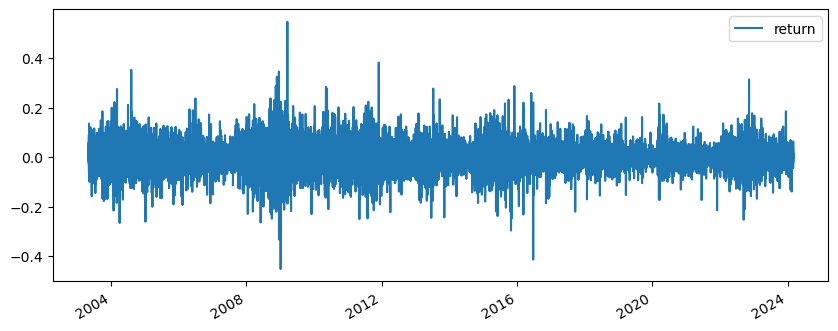

0.05522000000000005

In [9]:
# Retorno (close-open) normalizado

df1['return_next'] = df1['Close'].shift(-1) - df1['Open'].shift(-1)
return_range = df1['return_next'].max() - df1['return_next'].min()
df1['return_next'] = df1['return_next'] / return_range

df1['return'] = df1['Close'] - df1['Open']
return_range = df1['return'].max() - df1['return'].min()
df1['return'] = df1['return'] / return_range

df1.plot(y='return', figsize=(10,4))

plt.show()

df1['return'].min()
return_range

In [10]:
# label 1 CALL, label 0 PUT

df1['label'] = df1['return_next'].apply(lambda x: 1 if x>0 else 0)
df1.tail(10)

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic,RSI,datetime,return_next,return,label
2024-03-01 12:00:00,01.03.2024 12:00:00.000,1.08187,1.08247,1.08119,1.08129,12278.43,1.081090,0.000565,1.082219,1.079960,55.133080,47.029858,2024-03-01 12:00:00,-0.000181,-0.010503,0
2024-03-01 13:00:00,01.03.2024 13:00:00.000,1.08128,1.08153,1.08078,1.08127,13035.98,1.081154,0.000501,1.082157,1.080151,54.372624,46.888372,2024-03-01 13:00:00,-0.023180,-0.000181,0
2024-03-01 14:00:00,01.03.2024 14:00:00.000,1.08127,1.08206,1.07981,1.07999,16308.84,1.081108,0.000563,1.082235,1.079981,6.766917,38.835768,2024-03-01 14:00:00,0.063383,-0.023180,1
2024-03-01 15:00:00,01.03.2024 15:00:00.000,1.08000,1.08416,1.08000,1.08350,45959.82,1.081271,0.000743,1.082756,1.079785,84.827586,59.417811,2024-03-01 15:00:00,-0.007063,0.063383,0
2024-03-01 16:00:00,01.03.2024 16:00:00.000,1.08349,1.08368,1.08233,1.08310,9435.35,1.081384,0.000839,1.083062,1.079706,75.632184,57.061297,2024-03-01 16:00:00,0.012133,-0.007063,1
2024-03-01 17:00:00,01.03.2024 17:00:00.000,1.08309,1.08398,1.08288,1.08376,4686.64,1.081549,0.000963,1.083475,1.079623,90.804598,59.888099,2024-03-01 17:00:00,0.004346,0.012133,1
2024-03-01 18:00:00,01.03.2024 18:00:00.000,1.08376,1.08424,1.08315,1.08400,7922.03,1.081725,0.001072,1.083870,1.079581,94.582393,60.896230,2024-03-01 18:00:00,0.002173,0.004346,1
2024-03-01 19:00:00,01.03.2024 19:00:00.000,1.08400,1.08432,1.08381,1.08412,6756.80,1.081904,0.001160,1.084224,1.079584,95.565410,61.418360,2024-03-01 19:00:00,-0.007063,0.002173,0
2024-03-01 20:00:00,01.03.2024 20:00:00.000,1.08412,1.08412,1.08348,1.08373,4078.88,1.082034,0.001213,1.084460,1.079608,86.917960,58.676214,2024-03-01 20:00:00,-0.000905,-0.007063,0
2024-03-01 21:00:00,01.03.2024 21:00:00.000,1.08373,1.08405,1.08333,1.08368,5821.63,1.082112,0.001268,1.084648,1.079576,85.809313,58.316733,2024-03-01 21:00:00,NaN,-0.000905,0


In [11]:
# Removendo linhas com dados Nulos

df1.dropna(inplace=True)

df1.tail()

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic,RSI,datetime,return_next,return,label
2024-03-01 16:00:00,01.03.2024 16:00:00.000,1.08349,1.08368,1.08233,1.08310,9435.35,1.081384,0.000839,1.083062,1.079706,75.632184,57.061297,2024-03-01 16:00:00,0.012133,-0.007063,1
2024-03-01 17:00:00,01.03.2024 17:00:00.000,1.08309,1.08398,1.08288,1.08376,4686.64,1.081549,0.000963,1.083475,1.079623,90.804598,59.888099,2024-03-01 17:00:00,0.004346,0.012133,1
2024-03-01 18:00:00,01.03.2024 18:00:00.000,1.08376,1.08424,1.08315,1.08400,7922.03,1.081725,0.001072,1.083870,1.079581,94.582393,60.896230,2024-03-01 18:00:00,0.002173,0.004346,1
2024-03-01 19:00:00,01.03.2024 19:00:00.000,1.08400,1.08432,1.08381,1.08412,6756.80,1.081904,0.001160,1.084224,1.079584,95.565410,61.418360,2024-03-01 19:00:00,-0.007063,0.002173,0
2024-03-01 20:00:00,01.03.2024 20:00:00.000,1.08412,1.08412,1.08348,1.08373,4078.88,1.082034,0.001213,1.084460,1.079608,86.917960,58.676214,2024-03-01 20:00:00,-0.000905,-0.007063,0


In [12]:
df = df1.loc[:,['Open', 'High', 'Low', 'Close', 'Volume','SMA','Upper','Lower', 'Stochastic','RSI', 'label']]
df.tail()

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,label
2024-03-01 16:00:00,1.08349,1.08368,1.08233,1.08310,9435.35,1.081384,1.083062,1.079706,75.632184,57.061297,1
2024-03-01 17:00:00,1.08309,1.08398,1.08288,1.08376,4686.64,1.081549,1.083475,1.079623,90.804598,59.888099,1
2024-03-01 18:00:00,1.08376,1.08424,1.08315,1.08400,7922.03,1.081725,1.083870,1.079581,94.582393,60.896230,1
2024-03-01 19:00:00,1.08400,1.08432,1.08381,1.08412,6756.80,1.081904,1.084224,1.079584,95.565410,61.418360,0
2024-03-01 20:00:00,1.08412,1.08412,1.08348,1.08373,4078.88,1.082034,1.084460,1.079608,86.917960,58.676214,0


In [13]:
df.dtypes

Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
SMA           float64
Upper         float64
Lower         float64
Stochastic    float64
RSI           float64
label           int64
dtype: object

## Gerando datasets de treino e teste

In [14]:
# Normalizando dados
from sklearn.preprocessing import StandardScaler

features = df.drop(columns=['label'])

scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

df_normalized = pd.DataFrame(normalized_features, columns=features.columns, index=df.index)

df_normalized['label'] = df['label']

df_normalized

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,label
2003-05-04 21:00:00,-0.875151,-0.877515,-0.872084,-0.873529,0.184124,-0.875253,-0.902086,-0.847599,0.537962,3.332211,0
2003-05-04 22:00:00,-0.875939,-0.880348,-0.873347,-0.878573,0.105196,-0.875422,-0.901279,-0.848756,-1.266348,-1.785290,0
2003-05-04 23:00:00,-0.879013,-0.885622,-0.878557,-0.884248,0.188959,-0.875876,-0.899100,-0.851871,-1.554331,-2.536048,1
2003-05-05 00:00:00,-0.884846,-0.879404,-0.879031,-0.877233,0.206885,-0.875978,-0.899159,-0.852017,0.223498,-0.243906,0
2003-05-05 01:00:00,-0.879250,-0.883497,-0.883372,-0.886534,0.165813,-0.876546,-0.897653,-0.854680,-1.136395,-1.354029,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01 16:00:00,-1.185311,-1.189999,-1.188561,-1.188417,-0.337854,-1.202140,-1.214696,-1.188723,0.883651,0.465306,1
2024-03-01 17:00:00,-1.188463,-1.187638,-1.184219,-1.183215,-0.464166,-1.200840,-1.211459,-1.189381,1.407768,0.654044,1
2024-03-01 18:00:00,-1.183182,-1.185591,-1.182087,-1.181323,-0.378107,-1.199448,-1.208364,-1.189711,1.538268,0.721354,1
2024-03-01 19:00:00,-1.181291,-1.184962,-1.176877,-1.180377,-0.409101,-1.198041,-1.205592,-1.189685,1.572225,0.756216,0


In [15]:
# Teste
df_test = df_normalized.loc['2023-01-01':,:]  
display(df_test.head())
display(df_test.tail())

# Treino
df_train = df_normalized.loc[:'2022-12-31',:] 
display(df_train.head())
display(df_train.tail())

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,label
2023-01-01 22:00:00,-1.294004,-1.292481,-1.302631,-1.297268,-0.522930,-1.290215,-1.312026,-1.267388,0.023063,-2.295057,1
2023-01-01 23:00:00,-1.299837,-1.293977,-1.299395,-1.291278,-0.457614,-1.290298,-1.312067,-1.267513,0.967433,-0.125647,1
2023-01-02 00:00:00,-1.291088,-1.293111,-1.292842,-1.288519,-0.495141,-1.290243,-1.311947,-1.267523,1.402340,0.429371,0
2023-01-02 01:00:00,-1.288408,-1.290828,-1.292290,-1.293485,-0.577329,-1.290436,-1.311826,-1.268034,0.454562,-0.466195,0
2023-01-02 02:00:00,-1.293453,-1.299487,-1.296789,-1.299239,-0.546766,-1.290917,-1.310605,-1.270236,-0.388821,-1.123806,0


,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,label
2024-03-01 16:00:00,-1.185311,-1.189999,-1.188561,-1.188417,-0.337854,-1.202140,-1.214696,-1.188723,0.883651,0.465306,1
2024-03-01 17:00:00,-1.188463,-1.187638,-1.184219,-1.183215,-0.464166,-1.200840,-1.211459,-1.189381,1.407768,0.654044,1
2024-03-01 18:00:00,-1.183182,-1.185591,-1.182087,-1.181323,-0.378107,-1.199448,-1.208364,-1.189711,1.538268,0.721354,1
2024-03-01 19:00:00,-1.181291,-1.184962,-1.176877,-1.180377,-0.409101,-1.198041,-1.205592,-1.189685,1.572225,0.756216,0
2024-03-01 20:00:00,-1.180345,-1.186536,-1.179482,-1.183451,-0.480332,-1.197016,-1.203740,-1.189497,1.273507,0.573130,0


,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,label
2003-05-04 21:00:00,-0.875151,-0.877515,-0.872084,-0.873529,0.184124,-0.875253,-0.902086,-0.847599,0.537962,3.332211,0
2003-05-04 22:00:00,-0.875939,-0.880348,-0.873347,-0.878573,0.105196,-0.875422,-0.901279,-0.848756,-1.266348,-1.785290,0
2003-05-04 23:00:00,-0.879013,-0.885622,-0.878557,-0.884248,0.188959,-0.875876,-0.899100,-0.851871,-1.554331,-2.536048,1
2003-05-05 00:00:00,-0.884846,-0.879404,-0.879031,-0.877233,0.206885,-0.875978,-0.899159,-0.852017,0.223498,-0.243906,0
2003-05-05 01:00:00,-0.879250,-0.883497,-0.883372,-0.886534,0.165813,-0.876546,-0.897653,-0.854680,-1.136395,-1.354029,1


,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,label
2022-12-30 17:00:00,-1.294241,-1.288703,-1.288974,-1.283159,0.094205,-1.317944,-1.316751,-1.318355,1.696983,1.063532,0
2022-12-30 18:00:00,-1.282891,-1.287365,-1.285659,-1.289938,0.373369,-1.316292,-1.312500,-1.319332,1.220682,0.802533,0
2022-12-30 19:00:00,-1.289906,-1.290356,-1.289843,-1.291987,-0.001486,-1.314736,-1.309262,-1.319476,1.100287,0.724100,1
2022-12-30 20:00:00,-1.291955,-1.291222,-1.292132,-1.287573,-0.250749,-1.313273,-1.305578,-1.320261,1.359599,0.833707,0
2022-12-30 21:00:00,-1.287147,-1.292088,-1.287395,-1.289623,-0.306403,-1.311610,-1.302685,-1.319841,1.192796,0.747717,0


In [16]:
df_train.columns


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'Upper', 'Lower',
       'Stochastic', 'RSI', 'label'],
      dtype='object')

## Treinando o Modelo

In [17]:
# Separate features and output

y_train = df_train['label']
X_train = df_train.loc[:,['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'Upper', 'Lower','Stochastic', 'RSI']]

y_test = df_test['label']
X_test = df_test.loc[:,['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'Upper', 'Lower','Stochastic', 'RSI']]

In [18]:
print(X_test.shape)
print(y_test.shape)

print('%% of Class0 : %f y_test' % (np.count_nonzero(y_test == 0)/float(len(y_test))))
print('%% of Class1 : %f y_test' % (np.count_nonzero(y_test == 1)/float(len(y_test))))

(7280, 10)
(7280,)
% of Class0 : 0.499451 y_test
% of Class1 : 0.500549 y_test


In [19]:
print(X_train.shape)
print(y_train.shape)

print('%% of Class0 : %f y_train' % (np.count_nonzero(y_train == 0)/float(len(y_train))))
print('%% of Class1 : %f y_train' % (np.count_nonzero(y_train == 1)/float(len(y_train))))

(122821, 10)
(122821,)
% of Class0 : 0.498840 y_train
% of Class1 : 0.501160 y_train


In [40]:
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=2000, verbose=3)

clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3862           19.10m
         2           1.3862           18.71m
         3           1.3861           18.80m
         4           1.3860           18.41m
         5           1.3860           18.00m
         6           1.3859           17.87m
         7           1.3859           17.64m
         8           1.3858           17.64m
         9           1.3858           17.63m
        10           1.3857           17.65m
        11           1.3857           17.67m
        12           1.3856           17.70m
        13           1.3856           17.73m
        14           1.3855           17.65m
        15           1.3855           17.73m
        16           1.3854           17.75m
        17           1.3854           17.74m
        18           1.3853           17.78m
        19           1.3853           17.89m
        20           1.3852           17.91m
        21           1.3852           18.06m
        2

GradientBoostingClassifier(learning_rate=0.01, n_estimators=2000,
                           random_state=0, verbose=3)

## Testando o Model

In [41]:
accuracy = clf.score(X_train, y_train)
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.540478


In [42]:
pred = clf.predict(X_test)

In [43]:
df_trade = pd.DataFrame(X_test)
df_trade['label']  = y_test
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']

df_trade

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,label,pred,won
2023-01-01 22:00:00,-1.294004,-1.292481,-1.302631,-1.297268,-0.522930,-1.290215,-1.312026,-1.267388,0.023063,-2.295057,1,0,False
2023-01-01 23:00:00,-1.299837,-1.293977,-1.299395,-1.291278,-0.457614,-1.290298,-1.312067,-1.267513,0.967433,-0.125647,1,0,False
2023-01-02 00:00:00,-1.291088,-1.293111,-1.292842,-1.288519,-0.495141,-1.290243,-1.311947,-1.267523,1.402340,0.429371,0,0,True
2023-01-02 01:00:00,-1.288408,-1.290828,-1.292290,-1.293485,-0.577329,-1.290436,-1.311826,-1.268034,0.454562,-0.466195,0,0,True
2023-01-02 02:00:00,-1.293453,-1.299487,-1.296789,-1.299239,-0.546766,-1.290917,-1.310605,-1.270236,-0.388821,-1.123806,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01 16:00:00,-1.185311,-1.189999,-1.188561,-1.188417,-0.337854,-1.202140,-1.214696,-1.188723,0.883651,0.465306,1,0,False
2024-03-01 17:00:00,-1.188463,-1.187638,-1.184219,-1.183215,-0.464166,-1.200840,-1.211459,-1.189381,1.407768,0.654044,1,0,False
2024-03-01 18:00:00,-1.183182,-1.185591,-1.182087,-1.181323,-0.378107,-1.199448,-1.208364,-1.189711,1.538268,0.721354,1,0,False
2024-03-01 19:00:00,-1.181291,-1.184962,-1.176877,-1.180377,-0.409101,-1.198041,-1.205592,-1.189685,1.572225,0.756216,0,0,True


In [44]:
# Win/Loss

print(df_trade[df_trade['won'] == False]['won'].count())
print(df_trade[df_trade['won'] == True]['won'].count())

3556
3724


In [45]:
# % Win

won_percentage = df_trade[df_trade['won'] == True]['won'].count()*100/df_trade['won'].count()
print("Percentual dos Trades acertados: {:.2f}%".format(won_percentage))

Percentual dos Trades acertados: 51.15%


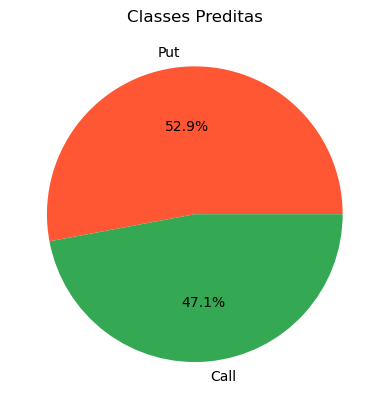

In [46]:
# Total de classes preditas

counts = df_trade['pred'].value_counts()
labels = ['Put', 'Call']
colors = ['#FF5733', '#34A853']
plt.pie(counts, labels=labels, colors = colors, autopct='%1.1f%%')
plt.title('Classes Preditas')
plt.show()

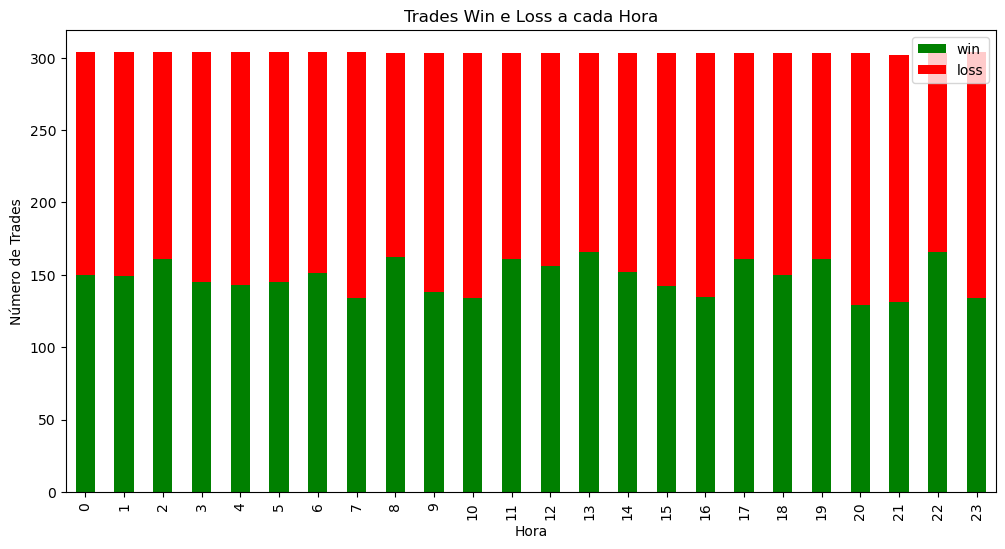

In [47]:
df_trade.index = pd.to_datetime(df_trade.index)

df_trade['hour'] = df_trade.index.hour

df_hour = df_trade.groupby(['hour', 'won'])['won'].count().unstack()

df_hour.columns = ['win', 'loss']

ax = df_hour.plot(kind='bar', stacked=True, figsize=(12,6), color=['green', 'red'])

ax.set_xlabel('Hora')
ax.set_ylabel('Número de Trades')
ax.set_title('Trades Win e Loss a cada Hora')

plt.show()

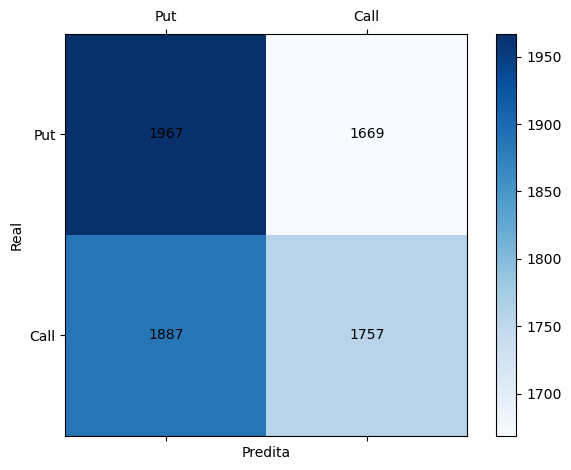

In [48]:
cm = confusion_matrix(y_test, pred)

class_names = ['Put', 'Call']

fig, ax = plt.subplots()
im = ax.matshow(cm, cmap=plt.cm.Blues)

cbar = ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       xlabel='Predita', ylabel='Real')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()

plt.show()